In [3]:
import sys
import numpy as np
import pandas as pd
import copy
from netCDF4 import Dataset
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw'

from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, list_yos,read_glider_nc,  adcp_import_data, edgetocentre, centretoedge

from src.data.beam_mapping import beam2enu, beam_from_center, vert_miss

In [4]:
bench_path = Path('../../sg637/2020-08-02_benchtests/bench_ncs')
sim_path = Path('../../sg637/2020-08-02_benchtests/simdive1')

In [ ]:
overview, mission_dict = adcp_import_data(bench_path)

In [ ]:
mission_dict

In [ ]:
foo = mission_dict['0001a']
bar = mission_dict['0001b']

In [ ]:
plt.pcolor(bar.amp_beam[:,1,:])

In [ ]:
plt.pcolor(foo.amp_beam[:,1,:])

In [ ]:
np.shape(foo.amp_beam)

In [7]:
overview, mission_dict = adcp_import_data(sim_path)

/home/callum/anaconda3/envs/sci/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:457: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


In [ ]:
overview

In [15]:
secs = np.arange(datetime(2020,8,3,14), datetime(2020,8,3,16), timedelta(seconds=30))

In [18]:
beam1 = secs[2::4]
beam2 = secs[3::4]
beam3 = secs[0::4]
beam4 = secs[1::4]

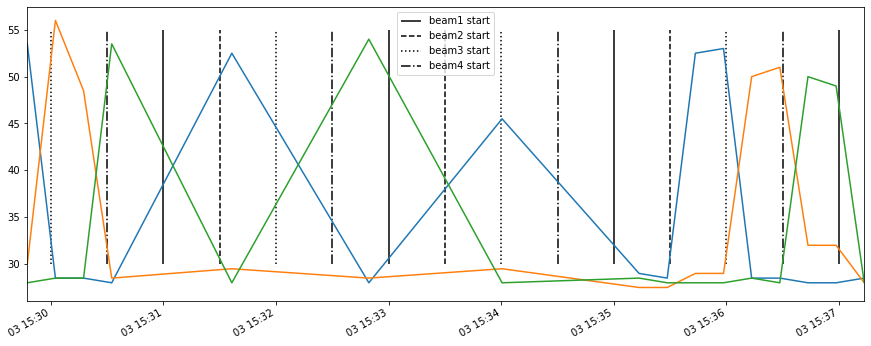

In [32]:
foo = mission_dict['0001a']
bar = mission_dict['0001b']
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(foo.time, foo.amp_beam[:,1,0])
ax.plot(foo.time, foo.amp_beam[:,1,1])
ax.plot(foo.time, foo.amp_beam[:,1,2])
#ax.set(xticks=secs);
ax.xaxis.set_minor_locator(MultipleLocator(2))

ax.set(xlim=[foo.time[0], foo.time[15]])
#x.grid=True
fig.autofmt_xdate()
ax.vlines(beam1, 30, 55, label='beam1 start', linestyle='-')
ax.vlines(beam2, 30, 55, label='beam2 start', linestyle='--')
ax.vlines(beam3, 30, 55, label='beam3 start', linestyle='dotted')
ax.vlines(beam4, 30, 55, label='beam4 start', linestyle='dashdot')


ax.legend()

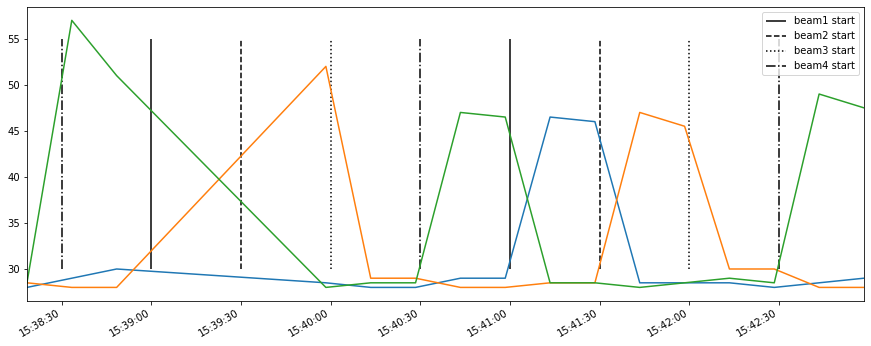

In [31]:
foo = mission_dict['0001b']
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(foo.time, foo.amp_beam[:,1,0])
ax.plot(foo.time, foo.amp_beam[:,1,1])
ax.plot(foo.time, foo.amp_beam[:,1,2])
#ax.set(xticks=secs);
ax.xaxis.set_minor_locator(MultipleLocator(2))

ax.set(xlim=[foo.time[0], foo.time[15]])
#x.grid=True
fig.autofmt_xdate()
ax.vlines(beam1, 30, 55, label='beam1 start', linestyle='-')
ax.vlines(beam2, 30, 55, label='beam2 start', linestyle='--')
ax.vlines(beam3, 30, 55, label='beam3 start', linestyle='dotted')
ax.vlines(beam4, 30, 55, label='beam4 start', linestyle='dashdot')


ax.legend()

In [ ]:
secs

In [ ]:
plt.pcolor(bar.amp_beam[:,1,:])

In [ ]:
foo.time

In [ ]:
bar.time

In [ ]:
plt.plot(np.arange(len(foo.time)), foo.time)